# Credit Card Fraud Detection

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from numpy.random import seed
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
seed(42)


from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import  classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, silhouette_score

import time
import warnings
warnings.filterwarnings("ignore")

# Data analysis & processing

In [2]:
df = pd.read_csv('creditcard.csv')
data=df

In [4]:
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


### Data exploration

#### Data balance analysis¶

In [5]:
print('Fraud and non-fraud percent(%): \n', np.round(df['Class'].value_counts().sort_values() / len(df) *100, 2))

Fraud and non-fraud percent(%): 
 1     0.17
0    99.83
Name: Class, dtype: float64


Text(0.5, 1.0, 'Nonfraud and Fraud count')

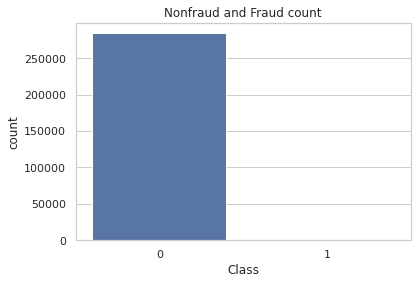

In [6]:
sns.countplot(df['Class'])
plt.title('Nonfraud and Fraud count')

#### Amount analysis

Text(0.5, 1.0, 'Median amount for Fraud and Nonfraud')

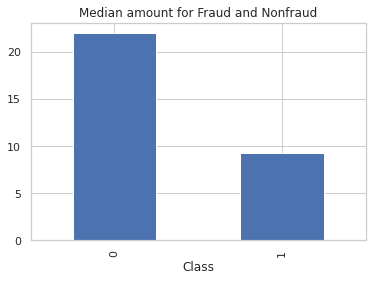

In [7]:
df.groupby('Class')['Amount'].median().plot.bar()
plt.title('Median amount for Fraud and Nonfraud')

<AxesSubplot:>

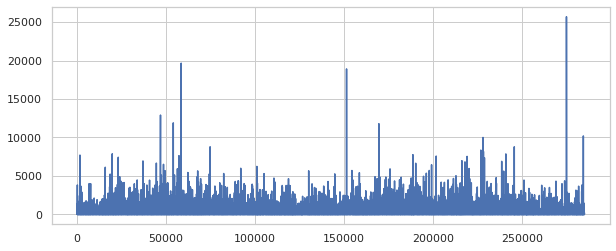

In [8]:
df['Amount'].plot(figsize = (10, 4))

In [9]:
print('The transaction peaks shows above: \n', df['Amount'].sort_values(ascending = False).head())

The transaction peaks shows above: 
 274771    25691.16
58465     19656.53
151296    18910.00
46841     12910.93
54018     11898.09
Name: Amount, dtype: float64


<AxesSubplot:>

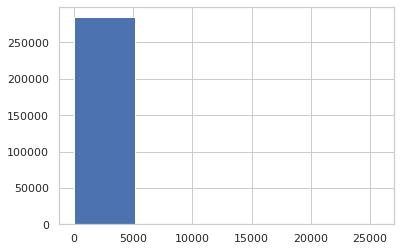

In [10]:
df['Amount'].hist(bins = 5)

In [11]:
print('Max of Amount: ', df['Amount'].max())
print('Min of Amount: ', df['Amount'].min())
print('Avg of Amount: ', df['Amount'].mean())

Max of Amount:  25691.16
Min of Amount:  0.0
Avg of Amount:  88.34961925087359


<AxesSubplot:ylabel='Amount'>

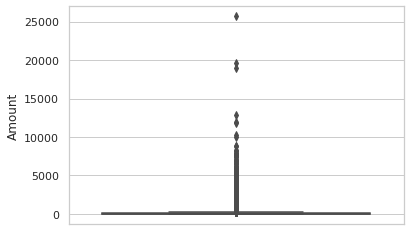

In [12]:
sns.boxplot(y = 'Amount', data = df)

In [13]:
q1 = df['Amount'].quantile(0.25)
q3 = df['Amount'].quantile(0.75)
iqr = q3 + 1.5*q3

In [14]:
df_extreme = df[ df['Amount'] > iqr]

#### Time analysis

Text(0.5, 1.0, 'Distribution of Time')

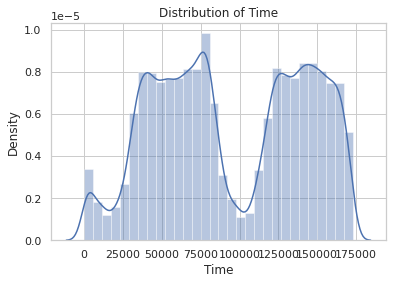

In [15]:
sns.distplot(df['Time'], bins = 30)
plt.title('Distribution of Time')

<AxesSubplot:xlabel='Class'>

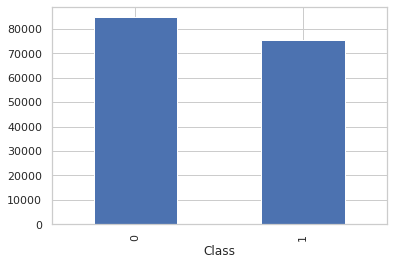

In [16]:
df.groupby('Class')['Time'].median().plot.bar()

<AxesSubplot:ylabel='Time'>

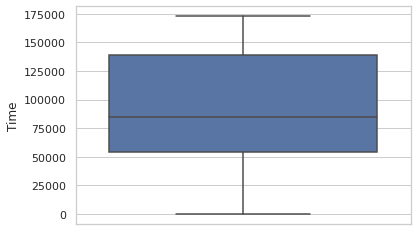

In [17]:
sns.boxplot(y = df['Time'])

#### Scale data


StandarScaler for Time \
RobustScaler for Amount

In [18]:
std_scaler = StandardScaler()
df['Amount_scaled'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop(['Amount'], inplace=True, axis = 1)

In [19]:
rob_scaler = RobustScaler()
df['Time_scaled'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df.drop(['Time'], inplace=True, axis = 1)

#### Split data

In [20]:
y = df['Class']
X = df.drop(['Class'], axis = 1)

In [21]:
X.shape, y.shape

((284807, 30), (284807,))

In [22]:
X.to_csv('X_without_sampling.csv', index=False)
y.to_csv('y_without_sampling.csv', index=False)

###  SMOTE sampling

Note - sampling is performed before data spliting which should be the case if future data is unbalanced, otherwise, sampling needs to be performed only on train set.

In [23]:
fraud_ind = np.array(data[data.Class == 1].index)
num_frauds = len(fraud_ind)
print(num_frauds)
normal_ind = np.array(data[data.Class == 0].index)
num_normal = len(normal_ind)
print(num_normal)

492
284315


In [24]:
sm = SMOTE(random_state=1)
X_resample, y_resample = sm.fit_resample(X, y)

In [25]:
X_resample.to_csv('X.csv', index=False)
y_resample.to_csv('y.csv', index=False)

In [26]:
X_resample.shape

(568630, 30)

In [27]:
y_resample

0         0
1         0
2         0
3         0
4         0
         ..
568625    1
568626    1
568627    1
568628    1
568629    1
Name: Class, Length: 568630, dtype: int64

In [28]:
counter = Counter(y_resample)
print(counter)

Counter({0: 284315, 1: 284315})


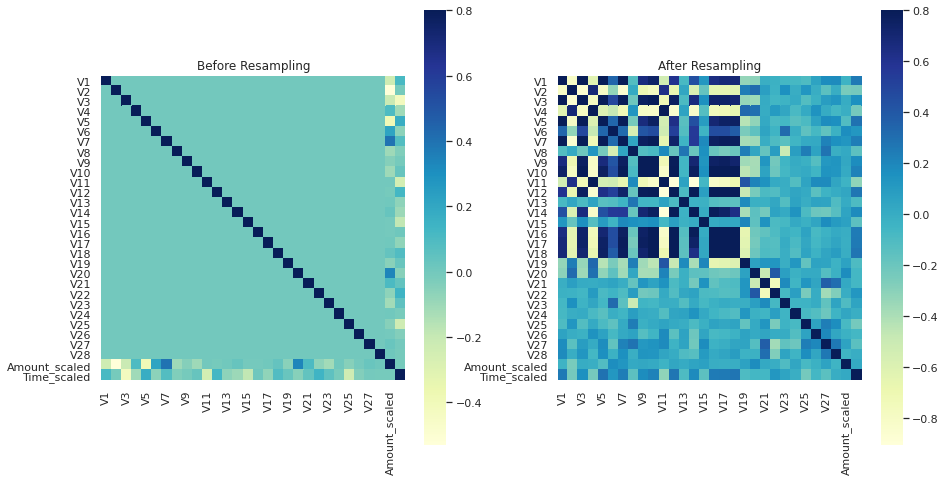

In [29]:
f, (ax1, ax2) = plt.subplots(1,2,figsize =( 15, 8))

sns.heatmap(X.corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Before Resampling')

sns.heatmap(X_resample.corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('After Resampling')

plt.show()